```
```

### backtrader 를 이용한 백테스팅 ###
---------------------------------------------------

* !pip install backtrader    -- > backtrader         1.9.78.123
* https://github.com/mementum/backtrader
* [backtrader docu] https://www.backtrader.com/docu/
* https://www.backtrader.com/docu/quickstart/quickstart/

In [1]:
import mariadb
import pandas   as pd
from datetime import datetime

In [2]:
try:
    conn = mariadb.connect(
        user="root",
        password="123",
        host="localhost",
        port=3306,
        database="home"
    )
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")

cursor = conn.cursor()
cursor.execute("select * from daily_price where  CODE = ?",[('100840')])
data = cursor.fetchall()
desc = list(map(lambda x : x[0],cursor.description))
conn.close()

df =  pd.DataFrame(data=data, columns=desc)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='raise')
df = df.set_index(df['date'],drop=True)
df = df.drop(columns=['code','date','chg'])
df.head(25)

,open,high,low,close,volume
date,,,,,
2022-01-03,18850,18900,18600,18800,8954
2022-01-04,18850,18850,18600,18600,8138
2022-01-05,18750,18750,18450,18450,7794
2022-01-06,18200,18500,18000,18050,12756
2022-01-07,18050,18550,18050,18450,8534
2022-01-10,18500,19550,18500,19500,60678
2022-01-11,19500,19850,19050,19850,126710
2022-01-12,19850,19850,19300,19350,27684
2022-01-13,19350,19350,18900,19000,16574


* Cerebro : 데이터와 전략을 이용해 브로커가 거래를 진행
* Data Feeds : 거래의 기초가 되는 데이터로 OHLCV 데이터 형태를 가져야 한다.
* Strategy : 거래를 진행하게되는 전략을 수립하는 부분
* Broker : 거래를 진행하는 주체로 자본, 수수료등 실제 거래의 요소들을 설정한다.

In [6]:
import backtrader as bt
import matplotlib as mpl
%matplotlib inline

Starting Portfolio Value: 20000000.00
2022-01-28T00:00:00, BUY CREATE 16337.79
1224 EA
2022-04-07T00:00:00, BUY CREATE 18369.11
1088 EA
2022-04-08T00:00:00, SELL CREATE 18950.0
1088 EA
2022-04-11T00:00:00, BUY CREATE 18215.87
1094 EA
2022-04-12T00:00:00, SELL CREATE 18875.0
1094 EA
2022-04-28T00:00:00, BUY CREATE 17717.79
1121 EA
2022-06-09T00:00:00, BUY CREATE 18414.27
1079 EA
2022-06-10T00:00:00, BUY CREATE 18316.85
1085 EA
2022-06-13T00:00:00, SELL CREATE 18927.5
1085 EA
2022-06-14T00:00:00, BUY CREATE 17904.69
1091 EA
2022-06-15T00:00:00, SELL CREATE 18745.0
1091 EA
2022-06-16T00:00:00, BUY CREATE 17028.12
1122 EA
2022-06-17T00:00:00, BUY CREATE 16697.22
1144 EA
2022-06-20T00:00:00, SELL CREATE 18317.5
1144 EA
2022-06-21T00:00:00, BUY CREATE 15873.00
1138 EA
2022-06-22T00:00:00, SELL CREATE 17927.5
1138 EA
2022-06-23T00:00:00, BUY CREATE 14778.35
1180 EA
2022-09-26T00:00:00, BUY CREATE 17339.95
1005 EA
2022-09-27T00:00:00, SELL CREATE 21040.0
1005 EA
2023-01-02T00:00:00, BUY CREATE

<IPython.core.display.Javascript object>

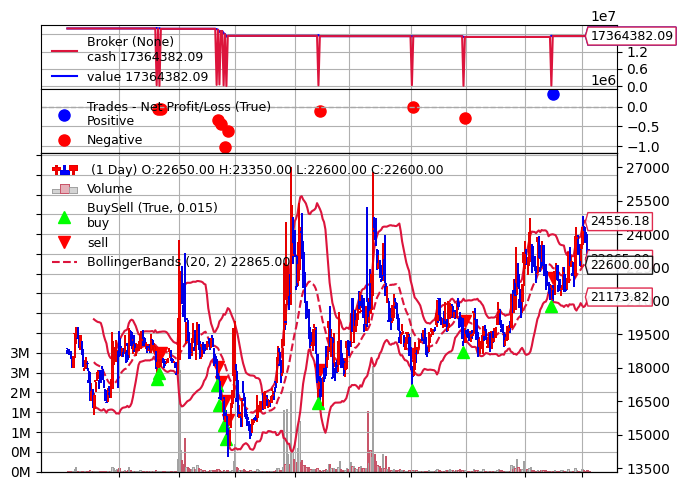

In [7]:
class MyStrategy(bt.Strategy) :
    params = (
        ('period',20),
        ('devfactor',2),
        ('debug',False)
    )

    def log(self, txt, dt=None) :
        dt = dt or self.data.datetime[0]
        if isinstance(dt, float) :
            df = bt.num2date(dt)
        print(f'{df.isoformat()}, {txt}')

    def  __init__(self) :
        self.bol1 = bt.ind.BollingerBands(period=self.p.period,devfactor=self.p.devfactor, plot=True)
        
    def next(self) :
        global size
        if not self.position :
            if self.data.low[0] < self.bol1.lines.bot[0] :
                bottom = self.bol1.lines.bot[0]
                size = int(self.broker.getcash() /bottom)
                self.buy(price=bottom, size = size)
                self.log(f'BUY CREATE {bottom:.2f}')
                print(size, 'EA')
        else :
            if self.data.high[0] < self.bol1.lines.mid[0] :
                self.sell(price=self.bol1.lines.mid[0], size=size)
                self.log(f'SELL CREATE {self.bol1.lines.mid[0]}')
                print(size, 'EA')

cerebro = bt.Cerebro()
cerebro.addstrategy(MyStrategy)
data = bt.feeds.PandasData(dataname=df)
cerebro.adddata(data)
cerebro.broker.setcash(20000000)
cerebro.broker.setcommission(0.00015)
print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.run()
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')
cerebro.plot(style='candle', barup='red', bardown='blue', volumn=False)[0][0]


In [19]:
class TestStrategy(bt.Strategy) :

    def log(self, txt, dt=None) :
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(TestStrategy)

    data = bt.feeds.PandasData(dataname=df)
    cerebro.adddata(data)

    cerebro.broker.setcash(100000.0)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run()

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2022-01-03, Close, 18800.00
2022-01-04, Close, 18600.00
2022-01-05, Close, 18450.00
2022-01-06, Close, 18050.00
2022-01-07, Close, 18450.00
2022-01-10, Close, 19500.00
2022-01-11, Close, 19850.00
2022-01-12, Close, 19350.00
2022-01-13, Close, 19000.00
2022-01-14, Close, 19450.00
2022-01-17, Close, 18600.00
2022-01-18, Close, 18100.00
2022-01-19, Close, 18050.00
2022-01-20, Close, 18400.00
2022-01-21, Close, 18200.00
2022-01-24, Close, 17450.00
2022-01-25, Close, 16800.00
2022-01-26, Close, 16950.00
2022-01-27, Close, 16300.00
2022-01-28, Close, 16800.00
2022-02-03, Close, 17350.00
2022-02-04, Close, 17700.00
2022-02-07, Close, 17850.00
2022-02-08, Close, 17450.00
2022-02-09, Close, 17750.00
2022-02-10, Close, 17500.00
2022-02-11, Close, 17150.00
2022-02-14, Close, 16550.00
2022-02-15, Close, 16450.00
2022-02-16, Close, 16800.00
2022-02-17, Close, 16900.00
2022-02-18, Close, 17250.00
2022-02-21, Close, 18050.00
2022-02-22, Close, 18600.00
2022-02-23, 

In [ ]:
import backtrader as bt
import matplotlib as mpl
%matplotlib inline

class MyStrategy(bt.Strategy):

    def log(self, txt, dt=None) :
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}, {txt}')

    def __init__(self):
        self.sma = bt.ind.SimpleMovingAverage(period=15)

    def next(self):
        if self.sma > self.data.close:
            self.log(f'close under sma {self.sma[0]} > {self.data.close[0]}')
            pass

        elif self.sma < self.data.close:
            self.log(f'close over sma  {self.sma[0]} < {self.data.close[0]}')
            pass

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MyStrategy)

    data = bt.feeds.PandasData(dataname=df)
    cerebro.adddata(data)

    cerebro.broker.setcash(100000.0)
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run()

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000.00
2022-02-22, Close, 18600.00
2022-02-22, BUY CREATE, 18600.00
2022-02-23, Order Canceled/Margin/Rejected
2022-02-23, Close, 18650.00
2022-02-23, BUY CREATE, 18650.00
2022-02-24, Order Canceled/Margin/Rejected
2022-02-24, Close, 18800.00
2022-02-24, BUY CREATE, 18800.00
2022-02-25, Order Canceled/Margin/Rejected
2022-02-25, Close, 18750.00
2022-02-25, BUY CREATE, 18750.00
2022-02-28, Order Canceled/Margin/Rejected
2022-02-28, Close, 19000.00
2022-02-28, BUY CREATE, 19000.00
2022-03-02, Order Canceled/Margin/Rejected
2022-03-02, Close, 18850.00
2022-03-02, BUY CREATE, 18850.00
2022-03-03, Order Canceled/Margin/Rejected
2022-03-03, Close, 18900.00
2022-03-03, BUY CREATE, 18900.00
2022-03-04, Order Canceled/Margin/Rejected
2022-03-04, Close, 18700.00
2022-03-04, BUY CREATE, 18700.00
2022-03-07, Order Canceled/Margin/Rejected
2022-03-07, Close, 18850.00
2022-03-07, BUY CREATE, 18850.00
2022-03-08, Order Canceled/Margin/Rejected
2022-03-08, Close, 18300.00
20

<IPython.core.display.Javascript object>

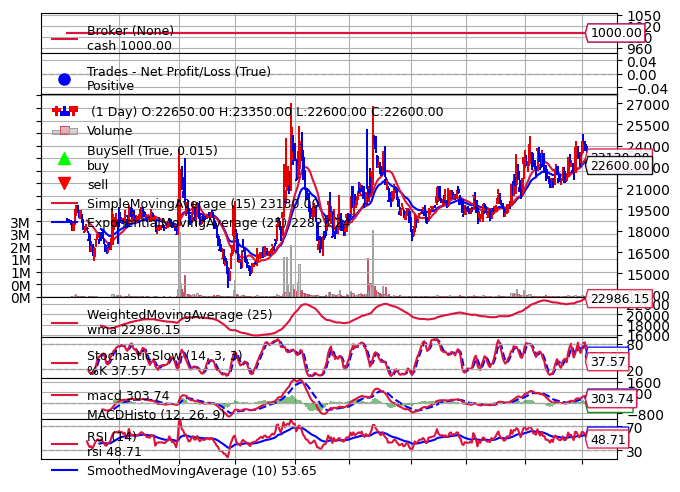

In [20]:
import backtrader as bt
import matplotlib as mpl
%matplotlib inline

# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('maperiod', 15),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

        # Indicators for the plotting show
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25,
                                            subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0], plot=False)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.sma[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.sma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(TestStrategy)

data = bt.feeds.PandasData(dataname=df)
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

# Set the commission
cerebro.broker.setcommission(commission=0.0)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Plot the result
cerebro.plot()[0][0]